In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .50 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(1, .05, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

In [4]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0]}

In [5]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'action': {}}

In [6]:
initial_conditions

{'action': {},
 'funds': 50000.0,
 'holdings': array([20.33801759, 31.79225653, 29.98484418, 38.59382899, 11.85709107,
        32.76354665, 12.82355701, 18.48728082, 23.18844192, 21.72734616,
        11.85837053, 36.40627618, 10.77705861, 23.95166795, 12.33325949,
        12.89706729, 15.68862202, 11.84141326, 37.84606256, 15.69078237,
        33.35322319, 34.11990606, 17.78877245, 14.25857909, 11.66029498,
        12.82032513, 50.21932709, 19.50596799, 12.08909238, 23.02604439,
        11.87880698, 10.67838065, 23.41368031, 21.61251293, 12.67323993,
        17.51922181, 18.96132897, 29.41044939, 21.5099352 , 24.98647171,
        26.89621995, 20.88464076, 32.30681203, 17.03532312, 18.72623637,
        30.18630073, 21.18303005, 13.79937331, 11.06343297, 40.76146727,
        10.13592069, 13.70262973, 18.53899545, 33.51438304, 13.74218335,
        11.81109585, 16.2803026 , 13.38422016, 16.00014147, 16.82550906,
        13.17124684, 12.2280695 , 26.29050765, 15.81344388, 14.30570866,
     

In [7]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = .001, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    if delF <1:
        if s['funds'] <1000:
            delF =100
    
    return({'delF':delF})

In [8]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [9]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [10]:
#change in F (revenue and spending accounted for)
def choose_agent(params, step, sL, s):
    n = params['population']
    rv = np.random.randint(0,n)
    return({'agent':rv})

In [11]:
def agent_action(params, step, sL, s, _input):
    
    a = _input['agent']
    h_a = s['holdings'][a]
    phat_a = s['prices'][a]
    s_a =  s['tokens'][a]
    p = s['spot_price']
    
    beta = params['beta']
    
    if p>phat_a: #equiv: pbar(0)>phat_a
        mech = 'burn'
        #approx for burn s.t. p=phat
        #armijo style
        amt = s_a
        
        def pbar(amt):
            output = withdraw_with_tax(amt, s['reserve'],s['supply'], params['invariant'], params['phi'], params['kappa'])
            
            if not(output[2])>0:
                return np.Infinity
            else:
                return output[2]
        
        
        while pbar(amt)< phat_a:
            amt = amt*beta
        
    else: # p<phat_a; #equiv pbar(0)<phat_a
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = h_a
        
        def pbar(amt):
            output = mint(amt, s['reserve'],s['supply'], params['invariant'], params['kappa'])
            
            if not(output[1])>0:
                return 0
            else:
                return output[1]
        
        while pbar(amt)> phat_a:
            amt = amt*beta
    
    #print(mech)
    #print(amt)
    #print(pbar(amt))
    key = 'action'
    value = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt)}
    
    return (key, value)

In [12]:
def resolve_action(params, step, sL, s):
    action = s['action']
    a = action['agent']
    amt = action['amt']
    h_a = s['holdings'][a]
    s_a =  s['tokens'][a]
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    
    if action['mech'] == 'bond':
        h_a = h_a-amt
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        s_a = s_a+dS
        P = spot_price(R, V0, kappa)
    
    elif action['mech'] == 'burn':
        s_a = s_a-amt
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        F = F + params['phi']*dR
        S = S-amt
        h_a = h_a + (1-params['phi'])*dR
        P = spot_price(R, V0, kappa)
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a})

In [13]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    h_a = _input['h_a']
    a = _input['a']
    
    h = s['holdings']
    h[a] = h_a
    
    key = 'holdings'
    value = h
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    s_a = _input['s_a']
    a = _input['a']
    
    tokens = s['tokens']
    tokens[a] = s_a
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [14]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agent
        },
        'variables': { 
            'action': agent_action, 
        }
    },
    {
      'policies': {
          'act': resolve_action,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [15]:
time_periods_per_run = 300
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [16]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 300), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([1.05575675, 0.99995981, 1.07538913, 0.966035  , 1.0013139 ,
       0.94349617, 1.0805429 , 1.04261766, 1.01213291, 1.01237292,
       1.01486181, 0.9966569 , 0.98037346, 0.97807533, 1.00994632,
       1.04992949, 1.01900569, 0.88221597, 1.03267212, 1.08239272,
       0.94267973, 0.90993285, 0.93632321, 0.97163616, 0.90915758,
       0.95462133, 0.97388143, 1.06825213, 0.93124217, 1.06852024,
       0.98294893, 0.95456386, 1.02781635, 1.03454555, 0.97418601,
       1.02067033, 1.04265517, 0.97787175, 1.02224961, 0.97930779,
       0.9625091 , 1.0385925 , 0.96176659, 0.98993556, 0.98446608,
       0.97656132, 1.00737812, 0.93539593, 1.01585395, 0.90643313,
       1.00918532, 1.03709662, 1.01238115, 0.94229606, 1.0075549 ,
       0.89961863, 0.93879688, 1.04698469, 1.0006752 , 0.90411258,
       1.08498571, 1.0597592 , 0.95157197, 1.03436115, 1.02897445,
       0.9757756 , 0.99319351, 1.12068079, 1.05267408, 1.

In [17]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [18]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a18650198>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a18650198>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS


In [19]:
experiment_index = 0
df = results[experiment_index]['result']

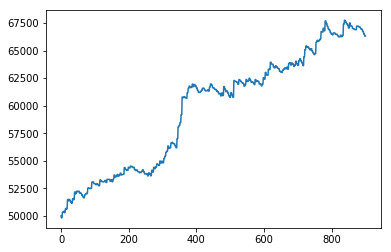

In [20]:
df.funds.plot()

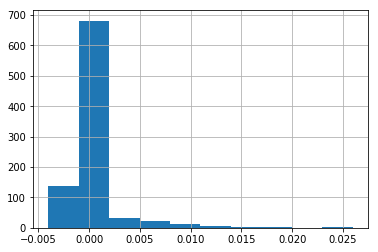

In [21]:
(df.funds.diff()/df.funds).hist()

In [22]:
rdf = df[df.substep == 3].copy()

In [23]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

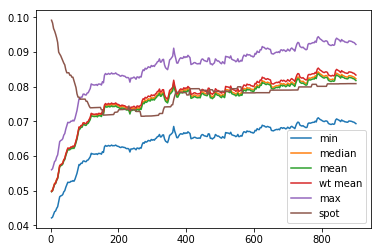

In [24]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','wt mean','max', 'spot'])

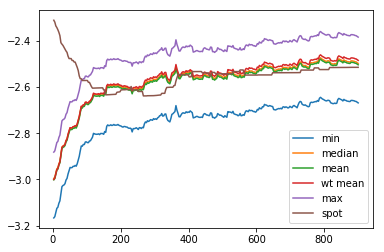

In [25]:
rdf.prices.apply(np.min).apply(np.log).plot()
rdf.prices.apply(np.median).apply(np.log).plot()
rdf.prices.apply(np.mean).apply(np.log).plot()
rdf.wt_mean_price.apply(np.log).plot()
rdf.prices.apply(np.max).apply(np.log).plot()
rdf.spot_price.apply(np.log).plot()
plt.legend(['min', 'median','mean','wt mean','max', 'spot'])

In [26]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

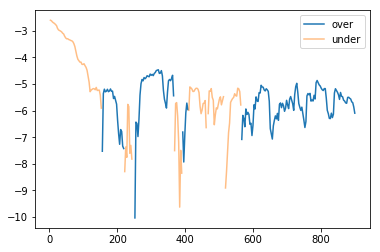

In [27]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [28]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

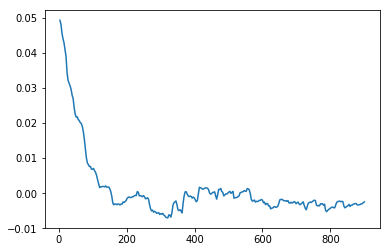

In [29]:
rdf.est_err.plot()

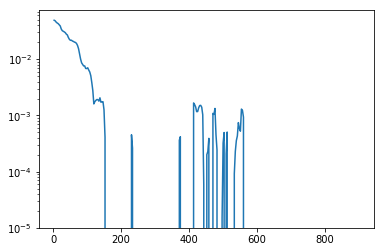

In [30]:
rdf.est_err.plot(logy=True)

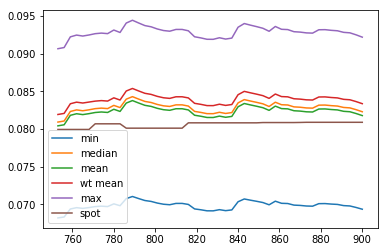

In [31]:
#tail T
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','wt mean','max', 'spot'])

In [32]:
bond_amts = [rdf.iloc[k].action['amt'] for k in range(time_periods_per_run) if rdf.iloc[k].action['mech']=='bond']
burn_amts = [rdf.iloc[k].action['amt'] for k in range(time_periods_per_run) if rdf.iloc[k].action['mech']=='burn']

(array([137.,   0.,   2.,   4.,   4.,   3.,   3.,   1.,   0.,   1.]),
 array([   0.        ,  138.42126797,  276.84253594,  415.2638039 ,
         553.68507187,  692.10633984,  830.52760781,  968.94887578,
        1107.37014374, 1245.79141171, 1384.21267968]),
 <a list of 10 Patch objects>)

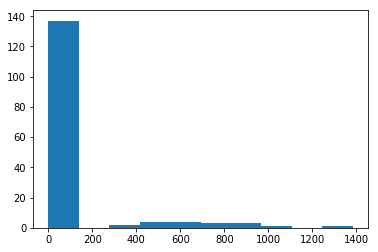

In [33]:
plt.hist(bond_amts)

(array([105.,   7.,  15.,   8.,   5.,   3.,   1.,   0.,   0.,   1.]),
 array([    0.        ,  2785.09684554,  5570.19369108,  8355.29053662,
        11140.38738216, 13925.4842277 , 16710.58107324, 19495.67791878,
        22280.77476431, 25065.87160985, 27850.96845539]),
 <a list of 10 Patch objects>)

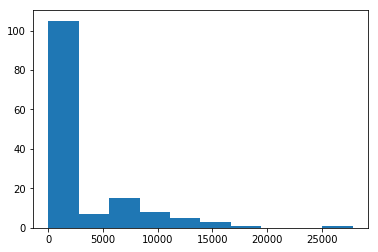

In [34]:
plt.hist(burn_amts)

In [35]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

In [36]:
rdf['resid'] = rdf.invariant-V0

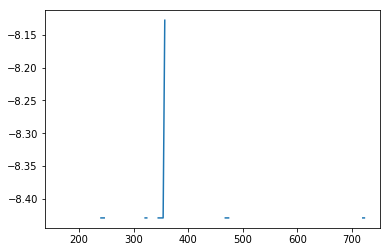

In [37]:
rdf.resid.apply(np.log10).plot()

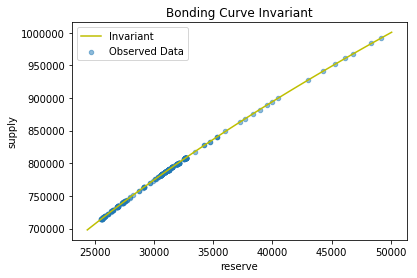

In [38]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

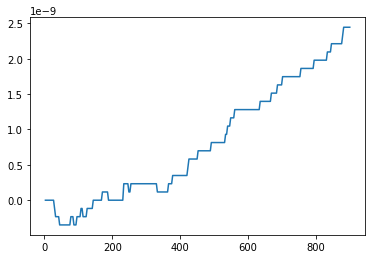

In [39]:
(rdf.tokens.apply(sum)-rdf.supply).plot()

In [40]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [41]:
rdf['gini_h'] = rdf.holdings.apply(gini)

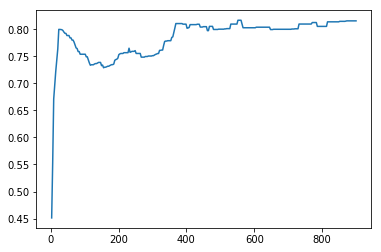

In [42]:
rdf.gini_h.plot()

In [43]:
rdf['gini_s'] = rdf.tokens.apply(gini)

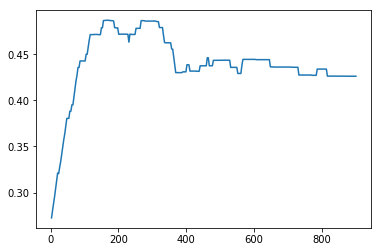

In [44]:
rdf.gini_s.plot()

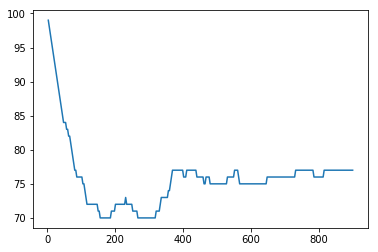

In [45]:
rdf.tokens.apply(np.count_nonzero).plot()

In [46]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [47]:
rdf['gini'] = rdf.asset_value.apply(gini)

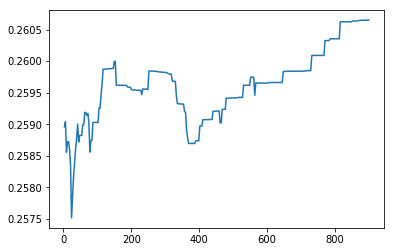

In [48]:
rdf.gini.plot()

In [49]:
rdf.tokens.sum()

array([1.58359831e+06, 2.53954837e+06, 1.72977365e+06, 2.58909798e+05,
       2.00447912e+06, 4.34712566e+06, 1.71865946e+06, 4.76148660e+06,
       9.92878597e+05, 1.62716230e+06, 5.65140598e+06, 1.90301166e+06,
       2.24915236e+06, 1.92328553e+06, 2.73727601e+06, 4.67848578e+06,
       8.13464415e+05, 7.77829546e+05, 3.24203299e+06, 3.50918060e+06,
       1.59700156e+06, 1.64915458e+06, 1.14010336e+05, 9.88789014e+05,
       1.96756453e+05, 1.31133146e+05, 1.49457555e+06, 3.61755642e+06,
       8.66323005e+05, 6.98145658e+06, 2.35926947e+06, 2.53609242e+06,
       1.57204344e+06, 1.42236427e+06, 3.46682550e+06, 3.10232156e+06,
       3.34706464e+06, 2.17806550e+06, 4.26928418e+06, 6.91476969e+04,
       2.31011982e+06, 1.99302041e+06, 4.04279403e+06, 8.17523174e+06,
       1.51241719e+06, 2.91773334e+06, 4.06065747e+06, 9.08030953e+05,
       5.02586812e+06, 2.12836269e+05, 1.78430537e+06, 1.44998943e+06,
       2.46250890e+06, 9.80664735e+05, 4.48646031e+04, 1.50872405e+06,
      